In [1]:
!which pip

/data/serrano/miniconda3/infinity_env/bin/pip


In [2]:
import airfrans as af
import matplotlib.pyplot as plt

In [3]:
PATH_TO_DATASET = "/data/serrano/airfrans/Dataset/"

In [4]:
import numpy as np

In [5]:
import torch

In [7]:
import os
import sys
from pathlib import Path
from torch_geometric.loader import DataLoader

import json
import hydra
import numpy as np
import torch
import torch.nn as nn
import wandb
from omegaconf import DictConfig, OmegaConf
from functools import partial
import torch.nn.functional as F

from infinity.utils.load_inr import load_inr_model
from infinity.utils.load_modulations import load_modulations
from infinity.data.dataset import GeometryDatasetFull, set_seed
from infinity.mlp import ResNet

In [58]:
from infinity.graph_metalearning import outer_step

# 1. Load sdf results

In [14]:
import yaml

In [38]:
dataset_name="airfrans"
data_to_encode="sdf"
run_name = "whole-plasma-390"#super-elevator-204"
inner_steps = 3

In [39]:
task = 'scarce'
LOAD_DIR = Path(os.getenv("WANDB_DIR")) / "airfrans" / task / "inr"

In [41]:
inr_train = torch.load(f"{LOAD_DIR}/{data_to_encode}/{run_name}.pt")

In [43]:
inr_state_dict = inr_train['inr']
cfg = inr_train['cfg']
alpha = inr_train['alpha']

In [14]:
data_dir = "/data/serrano/deeponet-fourier-data/"
task = "full"

In [49]:
from infinity.siren import ModulatedSiren

In [50]:
model_type = cfg.inr.model_type
latent_dim = cfg.inr.latent_dim
depth = cfg.inr.depth
hidden_dim = cfg.inr.hidden_dim
w0 = cfg.inr.w0
use_latent = cfg.inr.use_latent
modulate_scale = cfg.inr.modulate_scale
modulate_shift = cfg.inr.modulate_shift
hypernet_depth = cfg.inr.hypernet_depth
hypernet_width = cfg.inr.hypernet_width
loss_type = cfg.inr.loss_type
#gamma = cfg.inr.gamma
#scale_factor = cfg.inr.scale_factor

inr = ModulatedSiren(
            dim_in=2,
            dim_hidden=hidden_dim,
            dim_out=1,
            num_layers=depth,
            w0=w0,
            w0_initial=w0,
            use_bias=True,
            modulate_scale=modulate_scale,
            modulate_shift=modulate_shift,
            use_latent=use_latent,
            latent_dim=latent_dim,
            modulation_net_dim_hidden=hypernet_width,
            modulation_net_num_layers=hypernet_depth,
            last_activation=None,
        ).cuda()
inr.load_state_dict(inr_state_dict)
inr.eval()

ModulatedSiren(
  (net): Sequential(
    (0): SirenLayer(
      (linear): Linear(in_features=2, out_features=128, bias=True)
      (activation): Sine()
    )
    (1): SirenLayer(
      (linear): Linear(in_features=128, out_features=128, bias=True)
      (activation): Sine()
    )
    (2): SirenLayer(
      (linear): Linear(in_features=128, out_features=128, bias=True)
      (activation): Sine()
    )
    (3): SirenLayer(
      (linear): Linear(in_features=128, out_features=128, bias=True)
      (activation): Sine()
    )
  )
  (last_layer): SirenLayer(
    (linear): Linear(in_features=128, out_features=1, bias=True)
    (activation): Sine()
  )
  (last_activation): Identity()
  (modulation_net): LatentToModulation(
    (net): Linear(in_features=256, out_features=512, bias=True)
  )
)

In [51]:
task

'scarce'

In [52]:
data_dir = '/data/serrano/airfrans/'
print('data_dir', data_dir)

# train
with open(Path(data_dir) / 'Dataset/manifest.json', 'r') as f:
    manifest = json.load(f)

manifest_train = manifest[task + '_train']
testset = manifest[task + '_test'] if task != 'scarce' else manifest['full_test']
n = int(.9*len(manifest_train))

print("len manifest train", manifest_train, n)

trainset = manifest_train[:n] # was [:-n] ???
valset = manifest_train[n:]

ntrain = len(trainset)
nval = len(valset)

data_dir /data/serrano/airfrans/
len manifest train ['airFoil2D_SST_36.622_11.319_3.941_5.424_1.0_16.283', 'airFoil2D_SST_58.831_-3.563_2.815_4.916_10.078', 'airFoil2D_SST_43.327_8.905_4.236_6.511_10.744', 'airFoil2D_SST_89.151_4.462_0.974_4.094_1.0_19.856', 'airFoil2D_SST_87.422_2.992_1.895_3.128_1.0_10.656', 'airFoil2D_SST_42.531_-3.927_1.264_6.838_0.0_7.489', 'airFoil2D_SST_46.246_9.78_3.769_2.353_17.745', 'airFoil2D_SST_67.481_-1.259_5.136_2.438_18.882', 'airFoil2D_SST_45.701_-1.925_0.671_7.455_0.0_12.285', 'airFoil2D_SST_85.488_6.826_3.112_3.445_1.0_17.471', 'airFoil2D_SST_56.177_2.108_1.208_3.592_0.0_14.763', 'airFoil2D_SST_46.0_-0.095_2.322_1.874_16.58', 'airFoil2D_SST_81.846_10.688_0.402_4.721_0.0_11.955', 'airFoil2D_SST_56.749_1.468_1.967_7.293_1.0_8.866', 'airFoil2D_SST_41.403_-2.446_1.908_4.316_0.0_5.008', 'airFoil2D_SST_44.858_13.36_1.546_3.174_1.0_10.604', 'airFoil2D_SST_71.85_7.865_2.88_6.646_0.0_18.137', 'airFoil2D_SST_90.26_10.644_0.076_3.962_1.0_18.874', 'airFoil2D_SST

In [53]:
#default sample is none
latent_dim = cfg.inr.latent_dim
batch_size = 4
trainset = GeometryDatasetFull(trainset, key=None, latent_dim=latent_dim, norm=True, sample=None, n_boot=16000)
print("loaded train")
valset = GeometryDatasetFull(valset, key=None, latent_dim=latent_dim, sample=None, n_boot=16000, coef_norm=trainset.coef_norm)

100%|███████████████████████████████████████████████████████████████████████████| 180/180 [01:05<00:00,  2.73it/s]


coef_norm (array([ 4.99704629e-01,  1.16213085e-02,  6.07769814e+01,  5.06739235e+00,
        2.32000083e-01, -1.68674637e-03, -8.38373380e-05], dtype=float32), array([ 0.70514375,  0.33673635, 17.171833  ,  6.146387  ,  0.47567493,
        0.04210775,  0.06199972], dtype=float32), array([ 4.1501225e+01,  1.0193408e+01, -4.2369653e+02,  8.1722403e-04],
      dtype=float32), array([2.9134247e+01, 3.0195290e+01, 2.5707593e+03, 2.9320728e-03],
      dtype=float32))
loaded train


100%|█████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  2.90it/s]


coef_norm (array([ 4.99704629e-01,  1.16213085e-02,  6.07769814e+01,  5.06739235e+00,
        2.32000083e-01, -1.68674637e-03, -8.38373380e-05], dtype=float32), array([ 0.70514375,  0.33673635, 17.171833  ,  6.146387  ,  0.47567493,
        0.04210775,  0.06199972], dtype=float32), array([ 4.1501225e+01,  1.0193408e+01, -4.2369653e+02,  8.1722403e-04],
      dtype=float32), array([2.9134247e+01, 3.0195290e+01, 2.5707593e+03, 2.9320728e-03],
      dtype=float32))


In [54]:
train_loader = DataLoader(trainset, batch_size=1, shuffle=False)
# test
val_loader = DataLoader(valset, batch_size=1, shuffle=False)
device = torch.device("cuda")

In [36]:
#MIN_POS_SDF = torch.Tensor([-2.5, -1.75]).view(-1, 2)
#MAX_POS_SDF= torch.Tensor([4.5, 1.75]).view(-1,2)

In [61]:
num_points=4000
include_sdf=False

In [62]:
train_loader = DataLoader(trainset, batch_size=1, shuffle=False)
val_loader = DataLoader(valset, batch_size=1, shuffle=False)

if data_to_encode in ["sdf", "n"]:
    include_sdf = False
else:
    include_sdf = True

ntrain = len(train_loader.dataset)
ntest = len(val_loader.dataset)
fit_train_mse = 0
fit_test_mse = 0
mod_tr = torch.zeros(ntrain, latent_dim)
mod_te = torch.zeros(ntest, latent_dim)

for substep, (graph, idx) in enumerate(train_loader):
    inr.eval()
    if num_points is not None:
        mask = torch.randperm(graph.pos.shape[0])[:num_points]
    else:
        mask = ...

    if include_sdf:
        graph.pos = torch.cat([graph.pos, graph.sdf], axis=-1)

    if data_to_encode == "vx":
        graph.images = graph.vx
    elif data_to_encode == "vy":
        graph.images = graph.vy
    elif data_to_encode == "p":
        graph.images = graph.p
    elif data_to_encode == "nu":
        graph.images = graph.nu
    elif data_to_encode == "sdf":
        graph.images = graph.sdf
    elif data_to_encode == "n":
        graph.images = torch.cat([graph.nx, graph.ny], axis=-1)
        mask = graph.surface

    graph.pos = graph.pos[mask]
    graph.batch = graph.batch[mask]
    graph.images = graph.images[mask]
    graph.modulations = torch.zeros((len(graph), latent_dim))
    graph = graph.cuda()
    n_samples = len(graph)

    outputs = outer_step(
        inr,
        graph,
        inner_steps,
        alpha,
        is_train=False,
        return_reconstructions=True,
        gradient_checkpointing=False,
        use_rel_loss=False,
    )
    mod_tr[idx] = outputs["modulations"].cpu().detach()

    loss = outputs["loss"].cpu().detach()
    fit_train_mse += loss.item() * n_samples

print("train", data_to_encode, fit_train_mse / ntrain)

for substep, (graph, idx) in enumerate(val_loader):
    inr.eval()
    if num_points is not None:
        mask = torch.randperm(graph.pos.shape[0])[:num_points]
    else:
        mask = ...
    if include_sdf:
        graph.pos = torch.cat([graph.pos, graph.sdf], axis=-1)

    if data_to_encode == "vx":
        graph.images = graph.vx
    elif data_to_encode == "vy":
        graph.images = graph.vy
    elif data_to_encode == "p":
        graph.images = graph.p
    elif data_to_encode == "nu":
        graph.images = graph.nu
    elif data_to_encode == "sdf":
        graph.images = graph.sdf
    elif data_to_encode == "n":
        graph.images = torch.cat([graph.nx, graph.ny], axis=-1)
        mask = graph.surface

    graph.pos = graph.pos[mask]
    graph.batch = graph.batch[mask]
    graph.images = graph.images[mask]
    graph.modulations = torch.zeros((len(graph), latent_dim))
    graph = graph.cuda()
    n_samples = len(graph)

    outputs = outer_step(
        inr,
        graph,
        inner_steps,
        alpha,
        is_train=False,
        return_reconstructions=True,
        gradient_checkpointing=False,
        use_rel_loss=False,
    )
    mod_te[idx] = outputs["modulations"].cpu().detach()

    loss = outputs["loss"].cpu().detach()
    fit_test_mse += loss.item() * n_samples

print("test", data_to_encode, fit_test_mse / ntest)

train sdf 0.8414167112774319
test sdf 0.8276250660419464


In [47]:
fit_train_mse = 0
sdf_mod_tr = torch.zeros(ntrain, latent_dim)
for substep, (graph, idx) in enumerate(train_loader):
    mask = torch.randperm(graph.pos.shape[0])[:32000]
    inr.eval()
    graph.pos = (graph.pos[mask, ...] - MIN_POS_SDF)/(MAX_POS_SDF - MIN_POS_SDF)
    graph.modulations = torch.zeros(len(graph), latent_dim)
    graph.images = graph.x[mask, 4].unsqueeze(-1)
    graph.batch = graph.batch[mask]
    graph = graph.cuda()
    
    #graph.pos = torch.cat([graph.pos, graph.sdf], axis=-1)
    n_samples = len(graph)

    outputs = outer_step(
        inr,
        graph,
        inner_steps,
        alpha,
        is_train=False,
        return_reconstructions=True,
        gradient_checkpointing=False,
        use_rel_loss=False,
        loss_type="mse",
    )
    sdf_mod_tr[idx] = outputs['modulations'].cpu().detach()
    
    loss = outputs["loss"].cpu().detach()
    fit_train_mse += loss.item() * n_samples
print('train', fit_train_mse / ntrain)

train 1.5372954381278861e-06


In [46]:
inner_steps

3

In [49]:
fit_test_mse = 0
sdf_mod_te = torch.zeros(nval, latent_dim)

for substep, (graph, idx) in enumerate(val_loader):
    inr.eval()
    mask = torch.randperm(graph.pos.shape[0])[:32000]
    inr.eval()
    graph.pos = (graph.pos[mask, ...] - MIN_POS_SDF)/(MAX_POS_SDF - MIN_POS_SDF)
    graph.modulations = torch.zeros(len(graph), latent_dim)
    graph.images = graph.x[mask, 4].unsqueeze(-1)
    graph.batch = graph.batch[mask]
    graph = graph.cuda()
    
    outputs = outer_step(
        inr,
        graph,
        inner_steps,
        alpha,
        is_train=False,
        return_reconstructions=True,
        gradient_checkpointing=False,
        use_rel_loss=False,
        loss_type="mse",
    )
    sdf_mod_te[idx] = outputs['modulations'].cpu().detach()
    loss = outputs["loss"].cpu().detach()
    fit_test_mse += loss.item() * n_samples
print('test', fit_test_mse / nval)

test 1.8256302190877704e-06


In [51]:
graph.images

tensor([[ 2.3474],
        [ 0.3525],
        [-0.4876],
        ...,
        [-0.2890],
        [-0.4873],
        [-0.4835]], device='cuda:0')

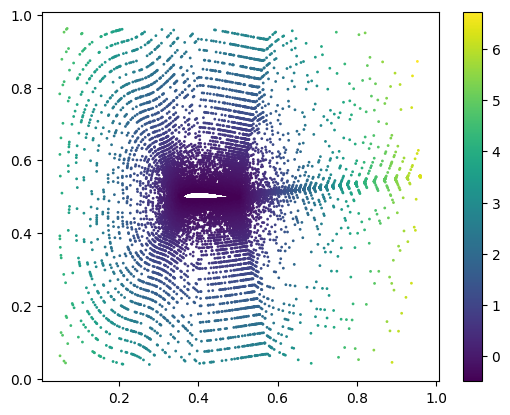

In [53]:
index = 1
mask = graph.batch == index
plt.scatter(graph.pos[..., 0].cpu().detach(), graph.pos[..., 1].cpu().detach(), c=graph.images.cpu().detach(), s=1)
plt.colorbar()

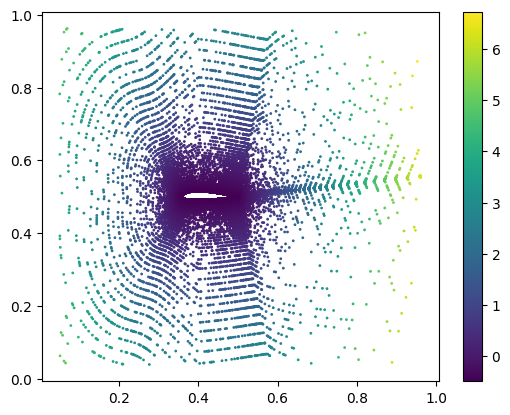

In [54]:
index = 1
mask = graph.batch == index
plt.scatter(graph.pos[..., 0].cpu().detach(), graph.pos[..., 1].cpu().detach(), c=outputs['reconstructions'].cpu().detach(), s=1)
plt.colorbar()

In [55]:
# save the inputs

In [56]:
sdf_modulations = {"z_train": sdf_mod_tr, "z_test": sdf_mod_te}

In [57]:
os.makedirs(f"/data/serrano/functa2functa/airfrans/inr/{data_to_encode}/{run_name}/", exist_ok=True)

In [59]:
#torch.save(sdf_modulations, f"/data/serrano/functa2functa/airfrans/inr/{data_to_encode}/{run_name}/sdf_modulations.pt")

In [24]:
sdf_modulations = torch.load(f"/data/serrano/functa2functa/airfrans/inr/{data_to_encode}/{run_name}/sdf_modulations.pt")

# 4. vx

In [10]:
from experiments.inr import ModulatedPositionalEmbedder

In [11]:
dataset_name="airfrans"
data_to_encode="vx"
run_name = "genial-waterfall-230"
inner_steps = 3

In [12]:
inr_train = torch.load(f"/data/serrano/functa2functa/airfrans/inr/{data_to_encode}/{run_name}.pt")

In [13]:
inr_state_dict = inr_train['inr']
cfg_inr = inr_train['cfg_inr']
alpha = inr_train['alpha']
data = inr_train['data']

In [14]:
data_dir = "/data/serrano/deeponet-fourier-data/"
task = "full"

In [15]:
inr = ModulatedPositionalEmbedder(input_dim=3,
                                  output_dim=1,
                                  num_frequencies=32,
                                  latent_dim=cfg_inr.latent_dim,
                                  width=cfg_inr.hidden_dim,
                                  depth=cfg_inr.depth,
                                  modulate_scale=cfg_inr.modulate_scale,
                                  modulate_shift=cfg_inr.modulate_shift).cuda()
inr.load_state_dict(inr_state_dict)
inr.eval()

ModulatedPositionalEmbedder(
  (embedding): PositionalEmbedder2()
  (layers): ModuleList(
    (0): Linear(in_features=192, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
  (latent_to_modulation): LatentToModulation(
    (net): Linear(in_features=256, out_features=1024, bias=True)
  )
)

In [16]:
data_dir = '/data/serrano/airfrans/'
print('data_dir', data_dir)

# train
with open(Path(data_dir) / 'Dataset/manifest.json', 'r') as f:
    manifest = json.load(f)

manifest_train = manifest[task + '_train']
testset = manifest[task + '_test'] if task != 'scarce' else manifest['full_test']
n = int(.9*len(manifest_train))

print("len manifest train", manifest_train, n)

trainset = manifest_train[:n] # was [:-n] ???
valset = manifest_train[n:]

ntrain = len(trainset)
nval = len(valset)

data_dir /data/serrano/airfrans/
len manifest train ['airFoil2D_SST_36.622_11.319_3.941_5.424_1.0_16.283', 'airFoil2D_SST_58.831_-3.563_2.815_4.916_10.078', 'airFoil2D_SST_43.327_8.905_4.236_6.511_10.744', 'airFoil2D_SST_89.151_4.462_0.974_4.094_1.0_19.856', 'airFoil2D_SST_87.422_2.992_1.895_3.128_1.0_10.656', 'airFoil2D_SST_42.531_-3.927_1.264_6.838_0.0_7.489', 'airFoil2D_SST_46.246_9.78_3.769_2.353_17.745', 'airFoil2D_SST_67.481_-1.259_5.136_2.438_18.882', 'airFoil2D_SST_45.701_-1.925_0.671_7.455_0.0_12.285', 'airFoil2D_SST_85.488_6.826_3.112_3.445_1.0_17.471', 'airFoil2D_SST_56.177_2.108_1.208_3.592_0.0_14.763', 'airFoil2D_SST_46.0_-0.095_2.322_1.874_16.58', 'airFoil2D_SST_81.846_10.688_0.402_4.721_0.0_11.955', 'airFoil2D_SST_56.749_1.468_1.967_7.293_1.0_8.866', 'airFoil2D_SST_41.403_-2.446_1.908_4.316_0.0_5.008', 'airFoil2D_SST_44.858_13.36_1.546_3.174_1.0_10.604', 'airFoil2D_SST_71.85_7.865_2.88_6.646_0.0_18.137', 'airFoil2D_SST_90.26_10.644_0.076_3.962_1.0_18.874', 'airFoil2D_SST

In [21]:
data_to_encode

'vx'

In [17]:
#default sample is none
latent_dim = cfg_inr.latent_dim
batch_size = 4
trainset = GeometryDataset(trainset, key=data_to_encode, latent_dim=latent_dim, norm=True, sample=None, n_boot=16000)
print("loaded train")
valset = GeometryDataset(valset, key=data_to_encode, latent_dim=latent_dim, sample=None, n_boot=16000, coef_norm=trainset.coef_norm)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 720/720 [04:53<00:00,  2.45it/s]


coef_norm (array([ 5.0067395e-01,  1.1246346e-02,  6.1503807e+01,  4.8500433e+00,
        2.3172970e-01, -1.6548282e-03, -8.6467640e-05], dtype=float32), array([ 0.7040369 ,  0.3364    , 17.780106  ,  6.284955  ,  0.4752076 ,
        0.04153645,  0.06240817], dtype=float32), array([ 4.2436943e+01,  9.6964874e+00, -4.5236975e+02,  7.9545029e-04],
      dtype=float32), array([2.9641506e+01, 3.0877468e+01, 2.9632727e+03, 2.9404047e-03],
      dtype=float32))
loaded train


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:31<00:00,  2.52it/s]


coef_norm (array([ 5.0067395e-01,  1.1246346e-02,  6.1503807e+01,  4.8500433e+00,
        2.3172970e-01, -1.6548282e-03, -8.6467640e-05], dtype=float32), array([ 0.7040369 ,  0.3364    , 17.780106  ,  6.284955  ,  0.4752076 ,
        0.04153645,  0.06240817], dtype=float32), array([ 4.2436943e+01,  9.6964874e+00, -4.5236975e+02,  7.9545029e-04],
      dtype=float32), array([2.9641506e+01, 3.0877468e+01, 2.9632727e+03, 2.9404047e-03],
      dtype=float32))


In [19]:
train_loader = DataLoader(trainset, batch_size=2, shuffle=True)
# test
val_loader = DataLoader(valset, batch_size=2, shuffle=True)
device = torch.device("cuda")

In [27]:
fit_train_mse = 0
surface_train_mse = 0
vx_mod_tr = torch.zeros(ntrain, latent_dim)

for substep, (graph, idx) in enumerate(train_loader):
    inr.eval()
    mask = torch.randperm(graph.pos.shape[0])[:32000]
    graph.pos = torch.cat([graph.pos[mask], graph.sdf[mask]], axis=-1)
    #graph.modulations = torch.zeros(len(graph), latent_dim)
    #graph.images = graph.y[mask, 0].unsqueeze(-1)
    graph.batch = graph.batch[mask]
    graph.images = graph.images[mask]
    graph = graph.cuda()
    
    n_samples = len(graph)

    outputs = outer_step(
        inr,
        graph,
        inner_steps,
        alpha,
        is_train=False,
        return_reconstructions=True,
        gradient_checkpointing=False,
        use_rel_loss=False,
        loss_type="mse",
    )
    vx_mod_tr[idx] = outputs['modulations'].cpu().detach()
    
    loss = outputs["loss"].cpu().detach()
    fit_train_mse += loss.item() * n_samples
    
print('train', fit_train_mse / ntrain)

train 0.00032902523501737355


In [28]:
fit_test_mse = 0
surface_test_mse = 0
vx_mod_te = torch.zeros(nval, latent_dim)

for substep, (graph, idx) in enumerate(val_loader):
    inr.eval()
    mask = torch.randperm(graph.pos.shape[0])[:32000]
    graph.pos = torch.cat([graph.pos[mask], graph.sdf[mask]], axis=-1)
    #graph.modulations = torch.zeros(len(graph), latent_dim)
    #graph.images = graph.y[mask, 0].unsqueeze(-1)
    graph.batch = graph.batch[mask]
    graph.images = graph.images[mask]
    graph = graph.cuda()
    
    n_samples = len(graph)

    outputs = outer_step(
        inr,
        graph,
        inner_steps,
        alpha,
        is_train=False,
        return_reconstructions=True,
        gradient_checkpointing=False,
        use_rel_loss=False,
        loss_type="mse",)

    vx_mod_te[idx] = outputs['modulations'].cpu().detach()
    loss = outputs["loss"].cpu().detach()
    fit_test_mse += loss.item() * n_samples
    
print('test', fit_test_mse / nval)

test 0.00046946892725827636


In [29]:
print('test', fit_test_mse / nval)

test 0.00046946892725827636


In [31]:
vx_mod_te.shape

torch.Size([80, 256])

In [32]:
vx_modulations = {"z_train": vx_mod_tr, "z_test": vx_mod_te}

In [34]:
os.makedirs(f"/home/serrano/Projects/INR_domain_decomposition/data/modulations/{data_to_encode}/", exist_ok=True)

In [108]:
#os.makedirs(f"/data/serrano/functa2functa/airfrans/inr/{data_to_encode}/{run_name}/", exist_ok=True)

In [35]:
torch.save(vx_modulations, f"/home/serrano/Projects/INR_domain_decomposition/data/modulations/{data_to_encode}/{run_name}.pt")

In [34]:
vx_modulations = torch.load(f"/data/serrano/functa2functa/airfrans/inr/{data_to_encode}/{run_name}/vx_modulations.pt")

# Obtain vy modulations

In [36]:
from experiments.inr import ModulatedPositionalEmbedder

In [37]:
dataset_name="airfrans"
data_to_encode="vy"
run_name = "deft-durian-231"
inner_steps = 3

In [38]:
inr_train = torch.load(f"/data/serrano/functa2functa/airfrans/inr/{data_to_encode}/{run_name}.pt")

In [39]:
inr_state_dict = inr_train['inr']
cfg_inr = inr_train['cfg_inr']
alpha = inr_train['alpha']
data = inr_train['data']

In [40]:
data_dir = "/data/serrano/deeponet-fourier-data/"
task = "full"

In [41]:
inr = ModulatedPositionalEmbedder(input_dim=3,
                                  output_dim=1,
                                  num_frequencies=32,
                                  latent_dim=cfg_inr.latent_dim,
                                  width=cfg_inr.hidden_dim,
                                  depth=cfg_inr.depth,
                                  modulate_scale=cfg_inr.modulate_scale,
                                  modulate_shift=cfg_inr.modulate_shift).cuda()
inr.load_state_dict(inr_state_dict)
inr.eval()

ModulatedPositionalEmbedder(
  (embedding): PositionalEmbedder2()
  (layers): ModuleList(
    (0): Linear(in_features=192, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
  (latent_to_modulation): LatentToModulation(
    (net): Linear(in_features=256, out_features=1024, bias=True)
  )
)

In [42]:
data_dir = '/data/serrano/airfrans/'
print('data_dir', data_dir)

# train
with open(Path(data_dir) / 'Dataset/manifest.json', 'r') as f:
    manifest = json.load(f)

manifest_train = manifest[task + '_train']
testset = manifest[task + '_test'] if task != 'scarce' else manifest['full_test']
n = int(.9*len(manifest_train))

print("len manifest train", manifest_train, n)

trainset = manifest_train[:n] # was [:-n] ???
valset = manifest_train[n:]

ntrain = len(trainset)
nval = len(valset)

data_dir /data/serrano/airfrans/
len manifest train ['airFoil2D_SST_36.622_11.319_3.941_5.424_1.0_16.283', 'airFoil2D_SST_58.831_-3.563_2.815_4.916_10.078', 'airFoil2D_SST_43.327_8.905_4.236_6.511_10.744', 'airFoil2D_SST_89.151_4.462_0.974_4.094_1.0_19.856', 'airFoil2D_SST_87.422_2.992_1.895_3.128_1.0_10.656', 'airFoil2D_SST_42.531_-3.927_1.264_6.838_0.0_7.489', 'airFoil2D_SST_46.246_9.78_3.769_2.353_17.745', 'airFoil2D_SST_67.481_-1.259_5.136_2.438_18.882', 'airFoil2D_SST_45.701_-1.925_0.671_7.455_0.0_12.285', 'airFoil2D_SST_85.488_6.826_3.112_3.445_1.0_17.471', 'airFoil2D_SST_56.177_2.108_1.208_3.592_0.0_14.763', 'airFoil2D_SST_46.0_-0.095_2.322_1.874_16.58', 'airFoil2D_SST_81.846_10.688_0.402_4.721_0.0_11.955', 'airFoil2D_SST_56.749_1.468_1.967_7.293_1.0_8.866', 'airFoil2D_SST_41.403_-2.446_1.908_4.316_0.0_5.008', 'airFoil2D_SST_44.858_13.36_1.546_3.174_1.0_10.604', 'airFoil2D_SST_71.85_7.865_2.88_6.646_0.0_18.137', 'airFoil2D_SST_90.26_10.644_0.076_3.962_1.0_18.874', 'airFoil2D_SST

In [43]:
data_to_encode

'vy'

In [44]:
#default sample is none
latent_dim = cfg_inr.latent_dim
batch_size = 4
trainset = GeometryDataset(trainset, key=data_to_encode, latent_dim=latent_dim, norm=True, sample=None, n_boot=16000)
print("loaded train")
valset = GeometryDataset(valset, key=data_to_encode, latent_dim=latent_dim, sample=None, n_boot=16000, coef_norm=trainset.coef_norm)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 720/720 [03:12<00:00,  3.74it/s]


coef_norm (array([ 5.0067395e-01,  1.1246346e-02,  6.1503807e+01,  4.8500433e+00,
        2.3172970e-01, -1.6548282e-03, -8.6467640e-05], dtype=float32), array([ 0.7040369 ,  0.3364    , 17.780106  ,  6.284955  ,  0.4752076 ,
        0.04153645,  0.06240817], dtype=float32), array([ 4.2436943e+01,  9.6964874e+00, -4.5236975e+02,  7.9545029e-04],
      dtype=float32), array([2.9641506e+01, 3.0877468e+01, 2.9632727e+03, 2.9404047e-03],
      dtype=float32))
loaded train


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:22<00:00,  3.57it/s]


coef_norm (array([ 5.0067395e-01,  1.1246346e-02,  6.1503807e+01,  4.8500433e+00,
        2.3172970e-01, -1.6548282e-03, -8.6467640e-05], dtype=float32), array([ 0.7040369 ,  0.3364    , 17.780106  ,  6.284955  ,  0.4752076 ,
        0.04153645,  0.06240817], dtype=float32), array([ 4.2436943e+01,  9.6964874e+00, -4.5236975e+02,  7.9545029e-04],
      dtype=float32), array([2.9641506e+01, 3.0877468e+01, 2.9632727e+03, 2.9404047e-03],
      dtype=float32))


In [52]:
train_loader = DataLoader(trainset, batch_size=2, shuffle=True)
# test
val_loader = DataLoader(valset, batch_size=2, shuffle=True)
device = torch.device("cuda")

In [53]:
fit_train_mse = 0
surface_train_mse = 0
vy_mod_tr = torch.zeros(ntrain, latent_dim)

for substep, (graph, idx) in enumerate(train_loader):
    inr.eval()
    mask = torch.randperm(graph.pos.shape[0])[:32000]
    graph.pos = torch.cat([graph.pos[mask], graph.sdf[mask]], axis=-1)
    #graph.modulations = torch.zeros(len(graph), latent_dim)
    #graph.images = graph.y[mask, 0].unsqueeze(-1)
    graph.batch = graph.batch[mask]
    graph.images = graph.images[mask]
    graph = graph.cuda()
    
    n_samples = len(graph)

    outputs = outer_step(
        inr,
        graph,
        inner_steps,
        alpha,
        is_train=False,
        return_reconstructions=True,
        gradient_checkpointing=False,
        use_rel_loss=False,
        loss_type="mse",
    )
    vy_mod_tr[idx] = outputs['modulations'].cpu().detach()
    
    loss = outputs["loss"].cpu().detach()
    fit_train_mse += loss.item() * n_samples
    
print('train', fit_train_mse / ntrain)

train 0.0003611590755503534


In [54]:
fit_test_mse = 0
surface_test_mse = 0
vy_mod_te = torch.zeros(nval, latent_dim)

for substep, (graph, idx) in enumerate(val_loader):
    inr.eval()
    mask = torch.randperm(graph.pos.shape[0])[:32000]
    graph.pos = torch.cat([graph.pos[mask], graph.sdf[mask]], axis=-1)
    #graph.modulations = torch.zeros(len(graph), latent_dim)
    #graph.images = graph.y[mask, 0].unsqueeze(-1)
    graph.batch = graph.batch[mask]
    graph.images = graph.images[mask]
    graph = graph.cuda()
    
    n_samples = len(graph)

    outputs = outer_step(
        inr,
        graph,
        inner_steps,
        alpha,
        is_train=False,
        return_reconstructions=True,
        gradient_checkpointing=False,
        use_rel_loss=False,
        loss_type="mse",)

    vy_mod_te[idx] = outputs['modulations'].cpu().detach()
    loss = outputs["loss"].cpu().detach()
    fit_test_mse += loss.item() * n_samples
    
print('test', fit_test_mse / nval)

test 0.00047535094381601084


In [55]:
print('test', fit_test_mse / nval)

test 0.00047535094381601084


In [56]:
vy_mod_te.shape

torch.Size([80, 256])

In [57]:
vy_modulations = {"z_train": vy_mod_tr, "z_test": vy_mod_te}

In [50]:
os.makedirs(f"/home/serrano/Projects/INR_domain_decomposition/data/modulations/{data_to_encode}/", exist_ok=True)

In [108]:
#os.makedirs(f"/data/serrano/functa2functa/airfrans/inr/{data_to_encode}/{run_name}/", exist_ok=True)

In [58]:
data_to_encode

'vy'

In [59]:
torch.save(vy_modulations, f"/home/serrano/Projects/INR_domain_decomposition/data/modulations/{data_to_encode}/{run_name}.pt")

In [34]:
vx_modulations = torch.load(f"/data/serrano/functa2functa/airfrans/inr/{data_to_encode}/{run_name}/vx_modulations.pt")

# Obtain p modulations

In [11]:
from experiments.inr import ModulatedPositionalEmbedder

In [13]:
dataset_name="airfrans"
data_to_encode="p"
run_name = "smart-waterfall-232"
inner_steps = 3

In [14]:
inr_train = torch.load(f"/data/serrano/functa2functa/airfrans/inr/{data_to_encode}/{run_name}.pt")

In [15]:
inr_state_dict = inr_train['inr']
cfg_inr = inr_train['cfg_inr']
alpha = inr_train['alpha']
data = inr_train['data']

In [16]:
data_dir = "/data/serrano/deeponet-fourier-data/"
task = "full"

In [17]:
inr = ModulatedPositionalEmbedder(input_dim=3,
                                  output_dim=1,
                                  num_frequencies=32,
                                  latent_dim=cfg_inr.latent_dim,
                                  width=cfg_inr.hidden_dim,
                                  depth=cfg_inr.depth,
                                  modulate_scale=cfg_inr.modulate_scale,
                                  modulate_shift=cfg_inr.modulate_shift).cuda()
inr.load_state_dict(inr_state_dict)
inr.eval()

ModulatedPositionalEmbedder(
  (embedding): PositionalEmbedder2()
  (layers): ModuleList(
    (0): Linear(in_features=192, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
  (latent_to_modulation): LatentToModulation(
    (net): Linear(in_features=256, out_features=1024, bias=True)
  )
)

In [18]:
data_dir = '/data/serrano/airfrans/'
print('data_dir', data_dir)

# train
with open(Path(data_dir) / 'Dataset/manifest.json', 'r') as f:
    manifest = json.load(f)

manifest_train = manifest[task + '_train']
testset = manifest[task + '_test'] if task != 'scarce' else manifest['full_test']
n = int(.9*len(manifest_train))

print("len manifest train", manifest_train, n)

trainset = manifest_train[:n] # was [:-n] ???
valset = manifest_train[n:]

ntrain = len(trainset)
nval = len(valset)

data_dir /data/serrano/airfrans/
len manifest train ['airFoil2D_SST_36.622_11.319_3.941_5.424_1.0_16.283', 'airFoil2D_SST_58.831_-3.563_2.815_4.916_10.078', 'airFoil2D_SST_43.327_8.905_4.236_6.511_10.744', 'airFoil2D_SST_89.151_4.462_0.974_4.094_1.0_19.856', 'airFoil2D_SST_87.422_2.992_1.895_3.128_1.0_10.656', 'airFoil2D_SST_42.531_-3.927_1.264_6.838_0.0_7.489', 'airFoil2D_SST_46.246_9.78_3.769_2.353_17.745', 'airFoil2D_SST_67.481_-1.259_5.136_2.438_18.882', 'airFoil2D_SST_45.701_-1.925_0.671_7.455_0.0_12.285', 'airFoil2D_SST_85.488_6.826_3.112_3.445_1.0_17.471', 'airFoil2D_SST_56.177_2.108_1.208_3.592_0.0_14.763', 'airFoil2D_SST_46.0_-0.095_2.322_1.874_16.58', 'airFoil2D_SST_81.846_10.688_0.402_4.721_0.0_11.955', 'airFoil2D_SST_56.749_1.468_1.967_7.293_1.0_8.866', 'airFoil2D_SST_41.403_-2.446_1.908_4.316_0.0_5.008', 'airFoil2D_SST_44.858_13.36_1.546_3.174_1.0_10.604', 'airFoil2D_SST_71.85_7.865_2.88_6.646_0.0_18.137', 'airFoil2D_SST_90.26_10.644_0.076_3.962_1.0_18.874', 'airFoil2D_SST

In [19]:
data_to_encode

'p'

In [20]:
#default sample is none
latent_dim = cfg_inr.latent_dim
batch_size = 4
trainset = GeometryDataset(trainset, key=data_to_encode, latent_dim=latent_dim, norm=True, sample=None, n_boot=16000)
print("loaded train")
valset = GeometryDataset(valset, key=data_to_encode, latent_dim=latent_dim, sample=None, n_boot=16000, coef_norm=trainset.coef_norm)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 720/720 [04:18<00:00,  2.78it/s]


coef_norm (array([ 5.0067395e-01,  1.1246346e-02,  6.1503807e+01,  4.8500433e+00,
        2.3172970e-01, -1.6548282e-03, -8.6467640e-05], dtype=float32), array([ 0.7040369 ,  0.3364    , 17.780106  ,  6.284955  ,  0.4752076 ,
        0.04153645,  0.06240817], dtype=float32), array([ 4.2436943e+01,  9.6964874e+00, -4.5236975e+02,  7.9545029e-04],
      dtype=float32), array([2.9641506e+01, 3.0877468e+01, 2.9632727e+03, 2.9404047e-03],
      dtype=float32))
loaded train


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:28<00:00,  2.82it/s]


coef_norm (array([ 5.0067395e-01,  1.1246346e-02,  6.1503807e+01,  4.8500433e+00,
        2.3172970e-01, -1.6548282e-03, -8.6467640e-05], dtype=float32), array([ 0.7040369 ,  0.3364    , 17.780106  ,  6.284955  ,  0.4752076 ,
        0.04153645,  0.06240817], dtype=float32), array([ 4.2436943e+01,  9.6964874e+00, -4.5236975e+02,  7.9545029e-04],
      dtype=float32), array([2.9641506e+01, 3.0877468e+01, 2.9632727e+03, 2.9404047e-03],
      dtype=float32))


In [21]:
train_loader = DataLoader(trainset, batch_size=2, shuffle=True)
# test
val_loader = DataLoader(valset, batch_size=2, shuffle=True)
device = torch.device("cuda")

In [23]:
fit_train_mse = 0
surface_train_mse = 0
p_mod_tr = torch.zeros(ntrain, latent_dim)

for substep, (graph, idx) in enumerate(train_loader):
    inr.eval()
    mask = torch.randperm(graph.pos.shape[0])[:32000]
    graph.pos = torch.cat([graph.pos[mask], graph.sdf[mask]], axis=-1)
    #graph.modulations = torch.zeros(len(graph), latent_dim)
    #graph.images = graph.y[mask, 0].unsqueeze(-1)
    graph.batch = graph.batch[mask]
    graph.images = graph.images[mask]
    graph = graph.cuda()
    
    n_samples = len(graph)

    outputs = outer_step(
        inr,
        graph,
        inner_steps,
        alpha,
        is_train=False,
        return_reconstructions=True,
        gradient_checkpointing=False,
        use_rel_loss=False,
        loss_type="mse",
    )
    p_mod_tr[idx] = outputs['modulations'].cpu().detach()
    
    loss = outputs["loss"].cpu().detach()
    fit_train_mse += loss.item() * n_samples
    
print('train', fit_train_mse / ntrain)

train 0.0005790733080680689


In [24]:
fit_test_mse = 0
surface_test_mse = 0
p_mod_te = torch.zeros(nval, latent_dim)

for substep, (graph, idx) in enumerate(val_loader):
    inr.eval()
    mask = torch.randperm(graph.pos.shape[0])[:32000]
    graph.pos = torch.cat([graph.pos[mask], graph.sdf[mask]], axis=-1)
    #graph.modulations = torch.zeros(len(graph), latent_dim)
    #graph.images = graph.y[mask, 0].unsqueeze(-1)
    graph.batch = graph.batch[mask]
    graph.images = graph.images[mask]
    graph = graph.cuda()
    
    n_samples = len(graph)

    outputs = outer_step(
        inr,
        graph,
        inner_steps,
        alpha,
        is_train=False,
        return_reconstructions=True,
        gradient_checkpointing=False,
        use_rel_loss=False,
        loss_type="mse",)

    p_mod_te[idx] = outputs['modulations'].cpu().detach()
    loss = outputs["loss"].cpu().detach()
    fit_test_mse += loss.item() * n_samples
    
print('test', fit_test_mse / nval)

test 0.0009558558514981997


In [26]:
print('test', fit_test_mse / nval)

test 0.0009558558514981997


In [27]:
p_mod_te.shape

torch.Size([80, 256])

In [28]:
p_modulations = {"z_train": p_mod_tr, "z_test": p_mod_te}

In [29]:
os.makedirs(f"/home/serrano/Projects/INR_domain_decomposition/data/modulations/{data_to_encode}/", exist_ok=True)

In [30]:
#os.makedirs(f"/data/serrano/functa2functa/airfrans/inr/{data_to_encode}/{run_name}/", exist_ok=True)

In [31]:
data_to_encode

'p'

In [32]:
torch.save(p_modulations, f"/home/serrano/Projects/INR_domain_decomposition/data/modulations/{data_to_encode}/{run_name}.pt")

In [34]:
#vx_modulations = torch.load(f"/data/serrano/functa2functa/airfrans/inr/{data_to_encode}/{run_name}/vx_modulations.pt")

# Obtain nu modulations

In [34]:
from experiments.inr import ModulatedPositionalEmbedder

In [35]:
dataset_name="airfrans"
data_to_encode="nu"
run_name = "lively-firebrand-233"
inner_steps = 3

In [36]:
inr_train = torch.load(f"/data/serrano/functa2functa/airfrans/inr/{data_to_encode}/{run_name}.pt")

In [37]:
inr_state_dict = inr_train['inr']
cfg_inr = inr_train['cfg_inr']
alpha = inr_train['alpha']
data = inr_train['data']

In [38]:
data_dir = "/data/serrano/deeponet-fourier-data/"
task = "full"

In [39]:
inr = ModulatedPositionalEmbedder(input_dim=3,
                                  output_dim=1,
                                  num_frequencies=32,
                                  latent_dim=cfg_inr.latent_dim,
                                  width=cfg_inr.hidden_dim,
                                  depth=cfg_inr.depth,
                                  modulate_scale=cfg_inr.modulate_scale,
                                  modulate_shift=cfg_inr.modulate_shift).cuda()
inr.load_state_dict(inr_state_dict)
inr.eval()

ModulatedPositionalEmbedder(
  (embedding): PositionalEmbedder2()
  (layers): ModuleList(
    (0): Linear(in_features=192, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
  (latent_to_modulation): LatentToModulation(
    (net): Linear(in_features=256, out_features=1024, bias=True)
  )
)

In [40]:
data_dir = '/data/serrano/airfrans/'
print('data_dir', data_dir)

# train
with open(Path(data_dir) / 'Dataset/manifest.json', 'r') as f:
    manifest = json.load(f)

manifest_train = manifest[task + '_train']
testset = manifest[task + '_test'] if task != 'scarce' else manifest['full_test']
n = int(.9*len(manifest_train))

print("len manifest train", manifest_train, n)

trainset = manifest_train[:n] # was [:-n] ???
valset = manifest_train[n:]

ntrain = len(trainset)
nval = len(valset)

data_dir /data/serrano/airfrans/
len manifest train ['airFoil2D_SST_36.622_11.319_3.941_5.424_1.0_16.283', 'airFoil2D_SST_58.831_-3.563_2.815_4.916_10.078', 'airFoil2D_SST_43.327_8.905_4.236_6.511_10.744', 'airFoil2D_SST_89.151_4.462_0.974_4.094_1.0_19.856', 'airFoil2D_SST_87.422_2.992_1.895_3.128_1.0_10.656', 'airFoil2D_SST_42.531_-3.927_1.264_6.838_0.0_7.489', 'airFoil2D_SST_46.246_9.78_3.769_2.353_17.745', 'airFoil2D_SST_67.481_-1.259_5.136_2.438_18.882', 'airFoil2D_SST_45.701_-1.925_0.671_7.455_0.0_12.285', 'airFoil2D_SST_85.488_6.826_3.112_3.445_1.0_17.471', 'airFoil2D_SST_56.177_2.108_1.208_3.592_0.0_14.763', 'airFoil2D_SST_46.0_-0.095_2.322_1.874_16.58', 'airFoil2D_SST_81.846_10.688_0.402_4.721_0.0_11.955', 'airFoil2D_SST_56.749_1.468_1.967_7.293_1.0_8.866', 'airFoil2D_SST_41.403_-2.446_1.908_4.316_0.0_5.008', 'airFoil2D_SST_44.858_13.36_1.546_3.174_1.0_10.604', 'airFoil2D_SST_71.85_7.865_2.88_6.646_0.0_18.137', 'airFoil2D_SST_90.26_10.644_0.076_3.962_1.0_18.874', 'airFoil2D_SST

In [41]:
data_to_encode

'nu'

In [42]:
#default sample is none
latent_dim = cfg_inr.latent_dim
batch_size = 4
trainset = GeometryDataset(trainset, key=data_to_encode, latent_dim=latent_dim, norm=True, sample=None, n_boot=16000)
print("loaded train")
valset = GeometryDataset(valset, key=data_to_encode, latent_dim=latent_dim, sample=None, n_boot=16000, coef_norm=trainset.coef_norm)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 720/720 [03:10<00:00,  3.79it/s]


coef_norm (array([ 5.0067395e-01,  1.1246346e-02,  6.1503807e+01,  4.8500433e+00,
        2.3172970e-01, -1.6548282e-03, -8.6467640e-05], dtype=float32), array([ 0.7040369 ,  0.3364    , 17.780106  ,  6.284955  ,  0.4752076 ,
        0.04153645,  0.06240817], dtype=float32), array([ 4.2436943e+01,  9.6964874e+00, -4.5236975e+02,  7.9545029e-04],
      dtype=float32), array([2.9641506e+01, 3.0877468e+01, 2.9632727e+03, 2.9404047e-03],
      dtype=float32))
loaded train


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:20<00:00,  3.86it/s]


coef_norm (array([ 5.0067395e-01,  1.1246346e-02,  6.1503807e+01,  4.8500433e+00,
        2.3172970e-01, -1.6548282e-03, -8.6467640e-05], dtype=float32), array([ 0.7040369 ,  0.3364    , 17.780106  ,  6.284955  ,  0.4752076 ,
        0.04153645,  0.06240817], dtype=float32), array([ 4.2436943e+01,  9.6964874e+00, -4.5236975e+02,  7.9545029e-04],
      dtype=float32), array([2.9641506e+01, 3.0877468e+01, 2.9632727e+03, 2.9404047e-03],
      dtype=float32))


In [46]:
train_loader = DataLoader(trainset, batch_size=2, shuffle=True)
# test
val_loader = DataLoader(valset, batch_size=2, shuffle=True)
device = torch.device("cuda")

In [59]:
len(train_loader.dataset.latent_dim)

AttributeError: 'GeometryDataset' object has no attribute 'latent_dim'

In [47]:
fit_train_mse = 0
surface_train_mse = 0
nu_mod_tr = torch.zeros(ntrain, latent_dim)

for substep, (graph, idx) in enumerate(train_loader):
    inr.eval()
    mask = torch.randperm(graph.pos.shape[0])[:32000]
    graph.pos = torch.cat([graph.pos[mask], graph.sdf[mask]], axis=-1)
    #graph.modulations = torch.zeros(len(graph), latent_dim)
    #graph.images = graph.y[mask, 0].unsqueeze(-1)
    graph.batch = graph.batch[mask]
    graph.images = graph.images[mask]
    graph = graph.cuda()
    
    n_samples = len(graph)

    outputs = outer_step(
        inr,
        graph,
        inner_steps,
        alpha,
        is_train=False,
        return_reconstructions=True,
        gradient_checkpointing=False,
        use_rel_loss=False,
        loss_type="mse",
    )
    p_mod_tr[idx] = outputs['modulations'].cpu().detach()
    
    loss = outputs["loss"].cpu().detach()
    fit_train_mse += loss.item() * n_samples
    
print('train', fit_train_mse / ntrain)

train 0.001982226386866791


In [48]:
fit_test_mse = 0
surface_test_mse = 0
nu_mod_te = torch.zeros(nval, latent_dim)

for substep, (graph, idx) in enumerate(val_loader):
    inr.eval()
    mask = torch.randperm(graph.pos.shape[0])[:32000]
    graph.pos = torch.cat([graph.pos[mask], graph.sdf[mask]], axis=-1)
    #graph.modulations = torch.zeros(len(graph), latent_dim)
    #graph.images = graph.y[mask, 0].unsqueeze(-1)
    graph.batch = graph.batch[mask]
    graph.images = graph.images[mask]
    graph = graph.cuda()
    
    n_samples = len(graph)

    outputs = outer_step(
        inr,
        graph,
        inner_steps,
        alpha,
        is_train=False,
        return_reconstructions=True,
        gradient_checkpointing=False,
        use_rel_loss=False,
        loss_type="mse",)

    p_mod_te[idx] = outputs['modulations'].cpu().detach()
    loss = outputs["loss"].cpu().detach()
    fit_test_mse += loss.item() * n_samples
    
print('test', fit_test_mse / nval)

test 0.002579811394389253


In [49]:
print('test', fit_test_mse / nval)

test 0.002579811394389253


In [50]:
p_mod_te.shape

torch.Size([80, 256])

In [51]:
nu_modulations = {"z_train": nu_mod_tr, "z_test": nu_mod_te}

In [52]:
os.makedirs(f"/home/serrano/Projects/INR_domain_decomposition/data/modulations/{data_to_encode}/", exist_ok=True)

In [53]:
#os.makedirs(f"/data/serrano/functa2functa/airfrans/inr/{data_to_encode}/{run_name}/", exist_ok=True)

In [55]:
data_to_encode

'nu'

In [56]:
torch.save(nu_modulations, f"/home/serrano/Projects/INR_domain_decomposition/data/modulations/{data_to_encode}/{run_name}.pt")

'deft-durian-231'

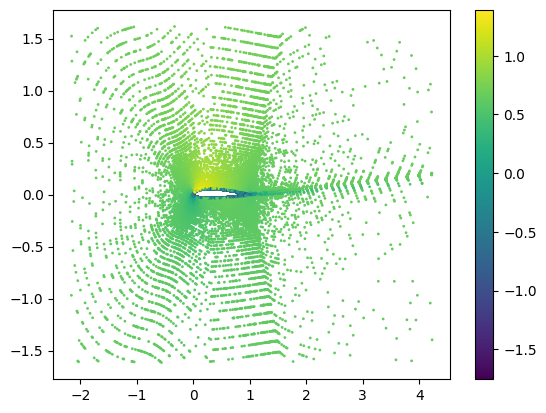

In [102]:
index = 0
mask = graph.batch == index
plt.scatter(graph.pos[mask, 0].cpu().detach(), graph.pos[mask, 1].cpu().detach(), c=graph.images[mask].cpu().detach(), s=1)
plt.colorbar()

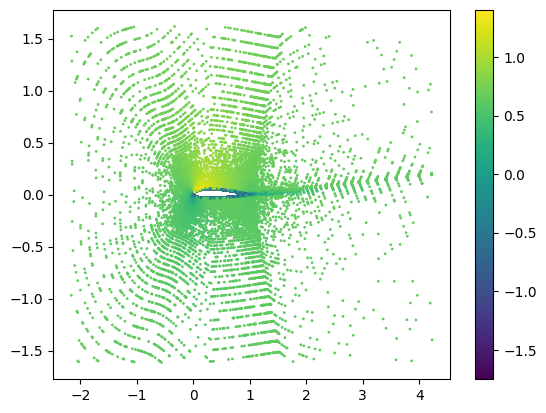

In [103]:
plt.scatter(graph.pos[mask, 0].cpu().detach(), graph.pos[mask, 1].cpu().detach(), c=outputs['reconstructions'][mask].cpu().detach(), s=1)
plt.colorbar()

# 3. Regression between the codes

In [35]:
from coral.mlp import ResNet

In [37]:
sdf_mod_tr, sdf_mod_te = sdf_modulations["z_train"], sdf_modulations["z_test"]

In [38]:
vx_mod_tr, vx_mod_te = vx_modulations["z_train"], vx_modulations["z_test"]

In [39]:
sigma_in = sdf_mod_tr.std()
sigma_out = vx_mod_tr.std()

In [40]:
train_modulation_set = torch.utils.data.TensorDataset(sdf_mod_tr/sigma_in, vx_mod_tr/sigma_out)
test_modulation_set = torch.utils.data.TensorDataset(sdf_mod_te/sigma_in, vx_mod_te/sigma_out)
train_modulation_loader = torch.utils.data.DataLoader(train_modulation_set, batch_size=64, shuffle=True)
test_modulation_loader = torch.utils.data.DataLoader(test_modulation_set, batch_size=64, shuffle=True)

In [79]:
resnet = ResNet(input_dim=latent_dim, hidden_dim=64, output_dim=latent_dim, depth=3).cuda()
optimizer = torch.optim.Adam(resnet.parameters(), lr=1e-3, weight_decay=1e-2)

In [80]:
epochs=1000
for step in range(epochs):
    train_mse = 0
    test_mse = 0
    for z_a, z_u in train_modulation_loader:
        z_a = z_a.cuda()
        z_u = z_u.cuda()
        n_samples = z_a.shape[0]
        
        pred = resnet(z_a)
        loss = ((pred-z_u)**2).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_mse += loss.item()*n_samples
        
    for z_a, z_u in test_modulation_loader:
        z_a = z_a.cuda()
        z_u = z_u.cuda()
        n_samples = z_a.shape[0]
        
        pred = resnet(z_a)
        loss = ((pred-z_u)**2).mean()
        test_mse += loss.item()*n_samples
    
    if step %100==0:
        print(step, "train: ", train_mse/ntrain, "test: ", test_mse / nval)
        

0 train:  0.9712548785739474 test:  0.788084614276886
100 train:  0.7934221161736382 test:  0.787446928024292
200 train:  0.789217037624783 test:  0.7611953735351562
300 train:  0.7897902184062534 test:  0.752584719657898
400 train:  0.7886293702655368 test:  0.7525754690170288
500 train:  0.7969504177570343 test:  0.7552257418632508
600 train:  0.7997250053617689 test:  0.753653347492218
700 train:  0.7938853290345934 test:  0.7604937076568603
800 train:  0.7936518602901035 test:  0.752433443069458
900 train:  0.7941507697105408 test:  0.754158616065979


In [81]:
vx_mod_tr.mean()

tensor(-6.9818e-05)

In [82]:
sdf_mod_tr.shape

torch.Size([720, 512])

In [83]:
index = 100

In [84]:
z_sample = sdf_mod_tr[index]/sigma_in

In [85]:
graph_sample = trainset.dataset[index]

In [86]:
coords = torch.cat([graph_sample.pos, graph_sample.x[..., 4].unsqueeze(-1)], axis=-1)
z_pred = resnet(z_sample.cuda().unsqueeze(0))
pred = inr.modulated_forward(coords.cuda(), sigma_out*z_pred)

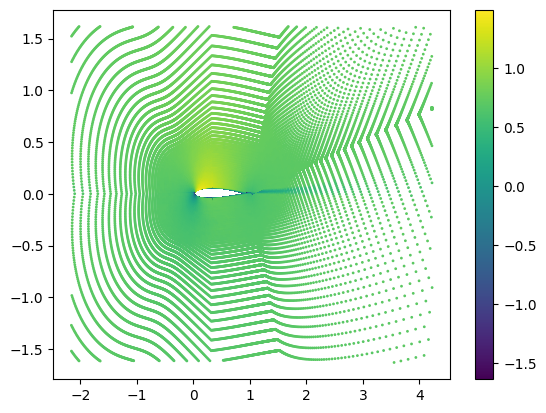

In [87]:
plt.scatter(graph_sample.pos[..., 0].cpu().detach(), graph_sample.pos[..., 1].cpu().detach(), c=pred.cpu().detach(), s=1)
plt.colorbar()

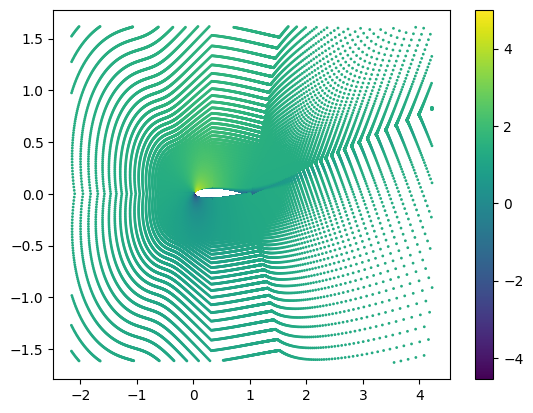

In [88]:
plt.scatter(graph_sample.pos[..., 0].cpu().detach(), graph_sample.pos[..., 1].cpu().detach(), c=graph_sample.y[..., 0].cpu().detach(), s=1)
plt.colorbar()

In [89]:
((pred.squeeze() - graph_sample.y.cuda()[..., 0])**2).mean()

tensor(1.1963, device='cuda:0', grad_fn=<MeanBackward0>)

In [90]:
pred.shape

torch.Size([177877, 1])